## Adding libraries

In [ ]:
!pip install pyts


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.8 MB/s eta 0:00:00


In [ ]:
%pip install yfinance

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader,ConcatDataset, TensorDataset,Subset,Dataset
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField as GADF
import plotly.graph_objs as go
import plotly.io as pio
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from pyts.image import GramianAngularField
from torchvision.models import resnet18
import torch.optim as optim


In [ ]:
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Importing Dataset

In [ ]:
start_date = '2023-08-01'
end_date = '2025-05-30'

In [ ]:
ticker = 'AAPL'
data = yf.download(ticker, start=start_date, end=end_date, interval='1h')
data


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Datetime,,,,,
2023-08-01 13:30:00+00:00,195.475006,196.729996,195.279999,196.235001,9552101
2023-08-01 14:30:00+00:00,196.115005,196.179993,195.330002,195.479996,4389743
2023-08-01 15:30:00+00:00,195.497299,196.145004,195.410004,196.110001,2991657
2023-08-01 16:30:00+00:00,195.729507,196.039993,195.350006,195.479996,2445951
2023-08-01 17:30:00+00:00,196.053299,196.270096,195.529999,195.735001,3075209
...,...,...,...,...,...
2025-05-29 15:30:00+00:00,199.419998,200.800003,198.509995,200.740005,6137020
2025-05-29 16:30:00+00:00,199.975006,200.449600,199.399994,199.399994,3935142


### Generating GADF images from time series

In [ ]:
def create_gaf_images(data, image_size=28):
    num_days = len(data) // (image_size)
    data = data[:num_days*image_size].reshape(num_days, image_size)
    close_prices=[]
    for i in range(num_days):
        close_prices.append(np.mean(data[i]))
    gadf = GADF(image_size=image_size)
    gadf_images= gadf.fit_transform(data)
    return gadf_images,close_prices


In [ ]:
close= np.array(data['Close'])
print(len(close))

3197


(106, 30, 30)


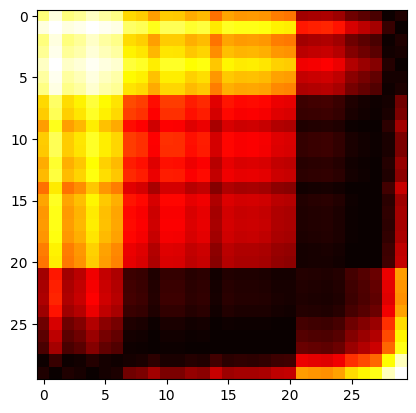

In [ ]:
gaf_images,close_prices= create_gaf_images(close,30)
plt.imshow(gaf_images[0],cmap='hot')
print(gaf_images.shape)

In [ ]:
def get_for_whole(data):
    images=[]
    prices=[]
    data1= data.drop(columns=['Volume'])
    for idx, i in enumerate(data1.columns):
      if(idx<1 or idx>3):
        continue
      close= np.array(data1[i])
      gaf_images,close_prices= create_gaf_images(close,30)
      images.append(gaf_images)
      if(i=='Close'):
        prices.append(close_prices)
        print(prices)
    images= np.transpose(images, (1, 0, 2, 3))
    return np.array(images), prices

images, prices= get_for_whole(data)


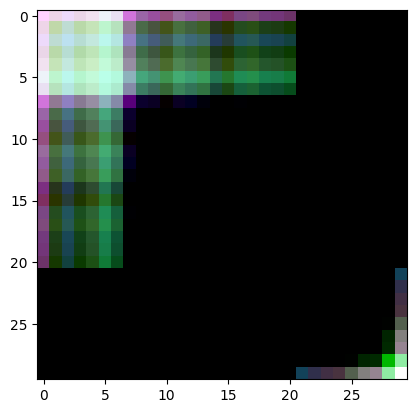

In [ ]:
image= images[0]
image= np.transpose(image, (1, 2, 0))
plt.imshow(image)


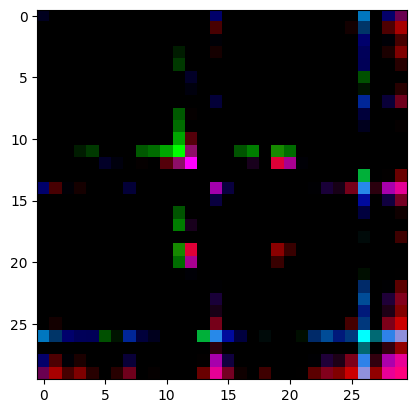

In [ ]:

image= images[1]
image= np.transpose(image, (1, 2, 0))
plt.imshow(image)

## Generate Encodeings by using CNN's on GADF images

In [ ]:
# This function is used to generate random noise image
def generate_noise_image():
    return torch.rand((1, 3, 224, 224))

# function to preprocess input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)
    return image

# function to get embeddings from ResNet model
def get_resnet_embeddings(image_path=None):

    resnet = models.resnet50(pretrained=True)
    resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if image_path is None:
        image = generate_noise_image()
    else:
        image = preprocess_image(image_path)
    embeddings = resnet(image)
    return embeddings

# function to get embeddings from DenseNet model
def get_densenet_embeddings(image_path=None):
    densenet = models.densenet121(pretrained=True)
    densenet = torch.nn.Sequential(*list(densenet.children())[:-1])
    if image_path is None:
        image = generate_noise_image()
    else:
        image = preprocess_image(image_path)
    embeddings = densenet(image)
    return embeddings

# **Approaches:**

## Forecasting Using LSTM's

### (1) Simple LSTM on time series data

*simple model of LSTM on the time series data*

In [ ]:
class LstmNet(nn.Module):
    def __init__(self,input_size,hidden_size,layers,output_size):
        super(LstmNet,self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(10,output_size)
    def forward(self,x):
        # print(x.shape)
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)

        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)
        out, (h_out, c_out) = self.lstm(x,(h0,c0))
        # print(out.shape,h_out.shape,c_out.shape)
        out = self.fc1(out[:,-1,:])
        return out.squeeze(1)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def prepare_dataset(data,length):
    x = []
    y = []
    for i in range(len(data)-length-1):
        x.append(data[i:i+length])
        y.append(data[i+length])
    return np.array(x),np.array(y)

def train_test_split(X,Y,percent):
    per = percent/100
    sz = len(X)
    xtrain = torch.Tensor(X[:int(sz*per)])
    ytrain = torch.Tensor(Y[:int(sz*per)])
    xtest = torch.Tensor(X[int(sz*per):])
    ytest = torch.Tensor(Y[int(sz*per):])
    return xtrain,ytrain,xtest,ytest

class DataPrep(Dataset):
  def __init__(self, inputs, targets):
      self.inputs = inputs
      self.targets = targets
  def __len__(self):
      return len(self.inputs)

  def __getitem__(self, index):
      X = self.inputs[index]
      Y = self.targets[index]
      return X, Y

In [ ]:
scaler = StandardScaler()
values = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
seq_len = 40
data_inp,data_tar = prepare_dataset(values,seq_len)
xtrain,ytrain,xtest,ytest = train_test_split(data_inp,data_tar,80)

In [ ]:
traindata = DataPrep(xtrain,ytrain)
testdata = DataPrep(xtest,ytest)
batch_size = 32
trainset = DataLoader(traindata,batch_size = batch_size,shuffle = True)
testset = DataLoader(testdata,batch_size = batch_size,shuffle = True)
for xbatch,ybatch in trainset:
    print(xbatch.shape,ybatch.shape)
    break

torch.Size([32, 40, 1]) torch.Size([32, 1])


In [ ]:
train_losses = []
test_losses = []
input_sz = 1
hidden_sz = 200
output_sz = 1
layers = 2
model = LstmNet(input_sz,hidden_sz,layers,output_sz).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
for epoch in range(1000):
    batch_loss = 0
    # correct = 0
    for xbatch,ybatch in trainset:
        xbatch,ybatch = xbatch.to(device),ybatch.to(device)
        out = model(xbatch)
        # print(ybatch.shape,out.shape)
        loss = criterion(out, ybatch.squeeze(1))
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
        # break

    train_loss = batch_loss/len(trainset)
    batch_loss = 0
    with torch.no_grad():
        for xbatch,ybatch in testset:
            xbatch,ybatch = xbatch.to(device),ybatch.to(device)
            out = model(xbatch)
            loss = criterion(out, ybatch.squeeze(1))
            batch_loss += loss.item()
    test_loss = batch_loss/len(testset)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if(epoch%10==9):
        print("Epoch: ", epoch+1, "|", "Train Loss : ", "{:.6f}".format(train_loss), "|", "Test Loss : ", "{:.6f}".format(test_loss))



Epoch:  10 | Train Loss :  0.253260 | Test Loss :  0.042384
Epoch:  20 | Train Loss :  0.052804 | Test Loss :  0.036260
Epoch:  30 | Train Loss :  0.117242 | Test Loss :  0.151076
Epoch:  40 | Train Loss :  0.035550 | Test Loss :  0.086166
Epoch:  50 | Train Loss :  0.087318 | Test Loss :  0.032997
Epoch:  60 | Train Loss :  0.032832 | Test Loss :  0.022129
Epoch:  70 | Train Loss :  0.042729 | Test Loss :  0.048303
Epoch:  80 | Train Loss :  0.062857 | Test Loss :  0.091013
Epoch:  90 | Train Loss :  0.069069 | Test Loss :  0.046381
Epoch:  100 | Train Loss :  0.071318 | Test Loss :  0.027676
Epoch:  110 | Train Loss :  0.053295 | Test Loss :  0.061760
Epoch:  120 | Train Loss :  0.038434 | Test Loss :  0.086257
Epoch:  130 | Train Loss :  0.011750 | Test Loss :  0.020859
Epoch:  140 | Train Loss :  0.020783 | Test Loss :  0.043561
Epoch:  150 | Train Loss :  0.043781 | Test Loss :  0.087839
Epoch:  160 | Train Loss :  0.051895 | Test Loss :  0.030904
Epoch:  170 | Train Loss :  0.041

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Predictions and actual values
train_pred = model(xtrain.to(device)).cpu().data.numpy()
train_actual = ytrain.data.numpy()
test_pred = model(xtest.to(device)).cpu().data.numpy()
test_actual = ytest.data.numpy()

# Concatenate results
pred = np.concatenate((train_pred, test_pred)).squeeze()
actual = np.concatenate((train_actual, test_actual)).squeeze()

# Uncomment if using scaler:
pred = scaler.inverse_transform(pred.reshape(-1, 1))
actual = scaler.inverse_transform(actual.reshape(-1, 1))

# Print shapes
print(f"Pred shape: {pred.shape}")
print(f"Actual shape: {actual.shape}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, pred))
print(f"RMSE: {rmse:.4f}")

Pred shape: (3156, 1)
Actual shape: (3156, 1)
RMSE: 2.6868


In [ ]:
import plotly.graph_objs as go


x_vals = [(i+1) for i in range(len(pred))]


trace1 = go.Scatter(
    x=x_vals,
    y=pred.squeeze(),
    name='Predicted (Unscaled)'
)

trace2 = go.Scatter(
    x=x_vals,
    y=actual.squeeze(),
    name='Actual (Unscaled)'
)

datas = [trace1, trace2]


layout = go.Layout(
    title='Prediction on Unscaled Data (80:20 Split, Normal LSTM)',
    xaxis=dict(title='Time Step'),
    yaxis=dict(title='Price'),
    legend=dict(x=0, y=1)
)


fig = go.Figure(data=datas, layout=layout)
fig.add_vline(
    x=len(train_pred),  # Split after training data
    line_width=1,
    line_dash="dash",
    line_color="red",
    annotation_text="Train-Test Split",
    annotation_position="top right"
)

fig.show()


*decent fitting of data
but failed near some of the troughs and was not very smooth*


### (2) CNNs on GADF generated images

*generating GADF images from the time series data and training a CNN
model to predict the 'close price' of the stock directly*


#### Image Data Prep

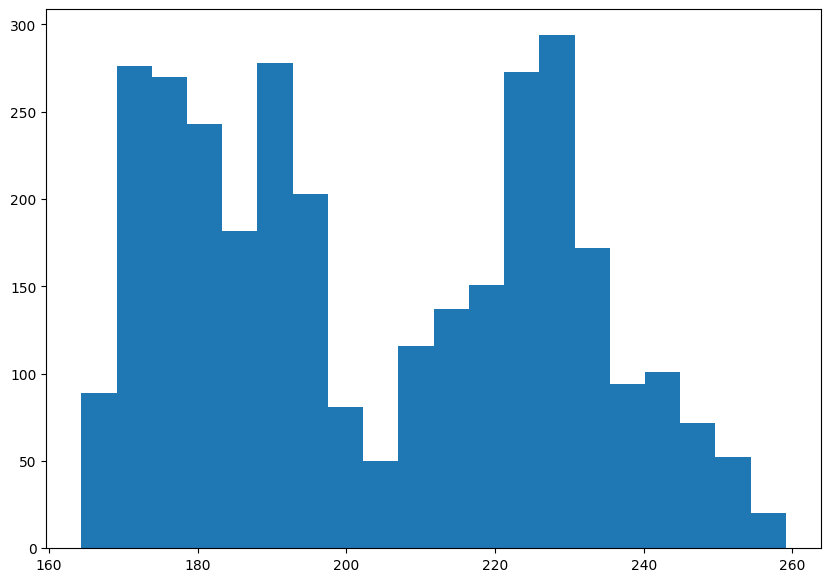

In [ ]:
values = data['Close'].values.reshape(1,-1)
images = []
labels = []
image_size = 10
data_size = 10
method = 'difference'
#method = 'summation'
sample_range = (0, 1)

for i in range(len(values[0])-data_size-33):
    gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
    gadf_image  = gaf.fit_transform(values[:,i:i+32])
    images.append(gadf_image)
    labels.append(values[:,i+32+1])
images = np.array(images).astype(np.float32)
labels = np.array(labels)

# scaler= MinMaxScaler()
scaler = StandardScaler()

# labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(labels, bins = 20)
plt.show()


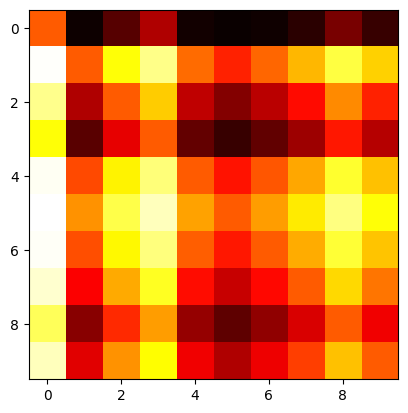

In [ ]:
plt.imshow(images[40].transpose(1,2,0),cmap='hot')

In [ ]:

class DataPrep(Dataset):
  def __init__(self, inputs, targets):
      self.inputs = inputs
      self.targets = targets
  def __len__(self):
      return len(self.inputs)

  def __getitem__(self, index):
      X = self.inputs[index]
      Y = self.targets[index]
      return X, Y
def split_prepare_data(dataset, batch_size=32, test_size=0.2):

    num_samples = len(dataset)
    num_test_samples = int(test_size * num_samples)
    num_train_samples = num_samples - num_test_samples
    indices = np.random.permutation(num_samples)
    train_indices = indices[:num_train_samples]
    #print(train_indices)
    test_indices = indices[num_train_samples:]
    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
    test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, test_loader


def prepare_dataset(input,labels,length):
    x = []
    y = []
    for i in range(len(input)-length-1):
        x.append(input[i:i+length])
        y.append(labels[i+length])
    return np.array(x),np.array(y)

def prepare_dataset_fromone(input,length):
    x = []
    y = []
    for i in range(len(input)-length-1):
        x.append(input[i:i+length])
        y.append(input[i+length])
    return np.array(x),np.array(y)

In [ ]:
values = data['Close'].values.reshape(1,-1)
images = []
labels = []
image_size = 32
data_size = 32
method = 'difference'
#method = 'summation'
sample_range = (0, 1)

for i in range(len(values[0])-data_size-1):
    gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
    gadf_image  = gaf.fit_transform(values[:,i:i+data_size])
    images.append(gadf_image)
    labels.append(values[:,i+data_size+1])
images = np.array(images).astype(np.float32)
labels = np.array(labels)

scaler = StandardScaler()

labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)

dataset = DataPrep(images,labels)
train_loader,test_loader = split_prepare_data(dataset)

In [ ]:

class GAFModel(nn.Module):
    def __init__(self, input_channels, output_size):
        super(GAFModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 3, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.resnet = resnet18(weights = True)
        # self.fc1 = nn.Linear(32 * 8 * 8, 256)
        # self.fc1 = nn.Linear(1000,256)
        # self.fc2 = nn.Linear(256,32)
        self.fc3 = nn.Linear(1000, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = self.resnet(x)
        # x = x.view(-1, 32 * 8 * 8)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00


In [ ]:

model = GAFModel(input_channels=1, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    pbar = tqdm(total = len(train_loader))
    for xbatch,ybatch in train_loader:
        optimizer.zero_grad()
        xbatch, ybatch = xbatch.to(device),ybatch.to(device)
        output = model(xbatch)
        loss = criterion(output,ybatch)+torch.sum(ybatch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.update(1)
    train_loss /= len(train_loader)
    pbar.close()

    test_loss = 0.0
    with torch.no_grad():
        for xbatch,ybatch in test_loader:
            xbatch, ybatch = xbatch.to(device),ybatch.to(device)
            output = model(xbatch)
            loss = criterion(output,ybatch)
            test_loss += loss.item()
        test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Testing Loss: {test_loss:.4f}")

pred = model(torch.Tensor(images).to(device)).cpu().data.numpy().squeeze()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.4MB/s]


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/10 - Training Loss: 2.8235 - Testing Loss: 1.5466


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/10 - Training Loss: 1.2979 - Testing Loss: 1.3053


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/10 - Training Loss: 1.1436 - Testing Loss: 1.1186


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/10 - Training Loss: 1.0882 - Testing Loss: 1.0146


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5/10 - Training Loss: 1.0316 - Testing Loss: 1.0633


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6/10 - Training Loss: 1.0225 - Testing Loss: 0.9955


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7/10 - Training Loss: 0.9767 - Testing Loss: 1.0340


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8/10 - Training Loss: 0.9761 - Testing Loss: 0.9915


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9/10 - Training Loss: 0.9386 - Testing Loss: 0.9842


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10/10 - Training Loss: 0.9470 - Testing Loss: 0.9850


In [ ]:
import numpy as np

actual = labels
print(pred.shape)
print(actual.shape)

# Uncomment if using scaler:
#pred = scaler.inverse_transform(pred.reshape(-1, 1))
#actual = scaler.inverse_transform(actual.reshape(-1, 1))

# Compute RMSE
rmse = np.sqrt(np.mean((pred - actual) ** 2))
print("RMSE:", rmse)


(3164,)
(3164,)
RMSE: 1.0034081


In [ ]:
import plotly.graph_objs as go

# Plotly scatter traces for predicted and actual data
trace1 = go.Scatter(
    x=[i + 1 for i in range(len(pred))],
    y=pred.squeeze(),
    name='Predicted Data'
)

trace2 = go.Scatter(
    x=[i + 1 for i in range(len(actual))],
    y=actual.squeeze(),
    name='Actual Data'
)

plot_data = [trace1, trace2]

layout = go.Layout(
    title='Prediction for 80:20 Split Using CNN (Unscaled)',
    xaxis=dict(title='Time Step'),
    yaxis=dict(title='Price'),
    legend=dict(x=0, y=1)
)

fig = go.Figure(data=plot_data, layout=layout)

# Optional: Show train/test split
fig.add_vline(
    x=len(pred),
    line_width=1,
    line_dash="dash",
    line_color="red",
    annotation_text="Train-Test Split",
    annotation_position="top right"
)

fig.show()


*not yield satisfactory results, as CNNs alone were unable to capture the sequential
properties of time series data effectively*


### (3) LSTM Image MODEL

*utilizing a sequence of
GADF images as input to a recurrent neural network (LSTM) model, with the
'close_price' as the target variable*

In [ ]:
values = data['Close'].values.reshape(1,-1)
images = []
labels = []
image_size = 32
data_size = 32
method = 'difference'
#method = 'summation'
sample_range = (0, 1)

for i in range(len(values[0])-data_size-1):
    gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
    gadf_image  = gaf.fit_transform(values[:,i:i+data_size])
    images.append(gadf_image)
    labels.append(values[:,i+data_size+1])
images = np.array(images).astype(np.float32).reshape(-1,image_size*image_size)

In [ ]:
scaler = StandardScaler()
labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)
plt.imshow(images[0].reshape(32,32))

In [ ]:
print(images.shape,labels.shape)

In [ ]:
seq_images,seq_labels = prepare_dataset(images,labels,length = 40)
print(seq_images.shape,labels.shape)

In [ ]:
dataset = DataPrep(seq_images,seq_labels)
train_loader,test_loader = split_prepare_data(dataset,batch_size = 32)

print(dataset[0][0].shape)

(40, 1024)


In [ ]:
for xbatch,ybatch in train_loader:
    print(xbatch.shape,ybatch.shape)
    break

torch.Size([32, 40, 1024]) torch.Size([32])


In [ ]:
class ImageLSTMNet(nn.Module):
    def __init__(self,input_size,hidden_size,layers,output_size):
        super(ImageLSTMNet,self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        # print(x.shape)
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)

        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)
        out, (h_out, c_out) = self.lstm(x,(h0,c0))
        # print(out.shape,h_out.shape,c_out.shape)
        out = self.fc1(out[:,-1,:])
        return out.squeeze(1)

In [ ]:
train_losses = []
test_losses = []
input_sz = 32*32
hidden_sz = 2048
output_sz = 1
layers = 1
LSTMmodel = ImageLSTMNet(input_sz,hidden_sz,layers,output_sz).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    pbar = tqdm(total = len(train_loader))
    for xbatch,ybatch in train_loader:
        optimizer.zero_grad()
        xbatch, ybatch = xbatch.to(device),ybatch.to(device)
        xbatch = xbatch.view(xbatch.size(0), xbatch.size(1), -1)
        output = LSTMmodel(xbatch)
        loss = criterion(output,ybatch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.update(1)
    train_loss /= len(train_loader)
    pbar.close()

    test_loss = 0.0
    with torch.no_grad():
        for xbatch,ybatch in test_loader:
            xbatch, ybatch = xbatch.to(device),ybatch.to(device)
            xbatch = xbatch.view(xbatch.size(0), xbatch.size(1), -1)
            output = LSTMmodel(xbatch)
            loss = criterion(output,ybatch)
            test_loss += loss.item()
        test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Testing Loss: {test_loss:.4f}")

pred = LSTMmodel(torch.Tensor(seq_images).to(device)).cpu().data.numpy().squeeze()

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/10 - Training Loss: 1.0468 - Testing Loss: 0.9596


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/10 - Training Loss: 0.9931 - Testing Loss: 0.9622


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/10 - Training Loss: 0.9608 - Testing Loss: 0.9507


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/10 - Training Loss: 0.9324 - Testing Loss: 0.9478


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5/10 - Training Loss: 0.8953 - Testing Loss: 0.9550


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6/10 - Training Loss: 0.8410 - Testing Loss: 0.9645


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7/10 - Training Loss: 0.8040 - Testing Loss: 0.9368


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8/10 - Training Loss: 0.7202 - Testing Loss: 0.9690


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9/10 - Training Loss: 0.6424 - Testing Loss: 0.9254


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10/10 - Training Loss: 0.6119 - Testing Loss: 0.9390


NameError: name 'seq_images' is not defined

In [ ]:
import numpy as np

actual = labels[41:]
print(pred.shape)
print(actual.shape)

# Uncomment if using scaler:
#pred = scaler.inverse_transform(pred.reshape(-1, 1))
#actual = scaler.inverse_transform(actual.reshape(-1, 1))

# Compute RMSE
rmse = np.sqrt(np.mean((pred - actual) ** 2))
print("RMSE:", rmse)



(3123,)
(3123,)
RMSE: 0.071826905


In [ ]:
import plotly.graph_objs as go

# Create traces for predicted and actual data
trace1 = go.Scatter(
    x=[i + 1 for i in range(len(pred))],
    y=pred.squeeze(),
    name='Predicted Data (Unscaled)'
)

trace2 = go.Scatter(
    x=[i + 1 for i in range(len(actual))],
    y=actual.squeeze(),
    name='Actual Data (Unscaled)'
)

plot_data = [trace1, trace2]

layout = go.Layout(
    title='Prediction for 80:20 Split (Unscaled)',
    xaxis=dict(title='Time Step'),
    yaxis=dict(title='Price'),
    legend=dict(x=0, y=1)
)

fig = go.Figure(data=plot_data, layout=layout)

# Optional: Add vertical line for train-test split
fig.add_vline(
    x=len(train_pred),
    line_width=1,
    line_dash="dash",
    line_color="red",
    annotation_text="Train-Test Split",
    annotation_position="top right"
)

fig.show()


*demonstrating more promising
results, as LSTMs are well-suited for modeling sequential data, and the GADF
images provided a suitable representation of the temporal patterns present in the
time series.*


### (4) Using ResNet-18 to encode images and passing embeddings to LSTM With Encoded Input

*a pre-trained CNN, such as
ResNet-50, is employed as a feature extractor to obtain embeddings from the
GADF-encoded images. These embeddings were then fed into a Long Short-Term
Memory (LSTM) network*


In [ ]:
values = data['Close'].values.reshape(1,-1)
images = []
labels = []
image_size = 32
data_size = 32
LATENT_SIZE = 1000
method = 'difference'
#method = 'summation'
sample_range = (0, 1)


In [ ]:
# ResNet model
resnet = models.resnet18(pretrained=True).float()
resnet.eval()
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
for i in range(len(values[0])-data_size-1):
    gaf = GramianAngularField(image_size=image_size, method=method, sample_range=sample_range)
    gadf_image  = gaf.fit_transform(values[:,i:i+data_size])
    gadf_image = np.transpose(np.repeat(gadf_image, 3, axis=0), (1, 2, 0))
    # print(gadf_image.shape)
    image = preprocess(gadf_image).unsqueeze(0)
    with torch.no_grad():
        encoding = resnet(image.float()).squeeze().numpy()
    images.append(encoding)
    labels.append(values[:,i+data_size+1])
images = np.array(images)
print(images.shape)

(3164, 1000)


In [ ]:
scaler = StandardScaler()

labels = scaler.fit_transform(labels).reshape(-1,).astype(np.float32)


In [ ]:
seq_images,seq_labels = prepare_dataset(images,labels,length = 40)
print(seq_images.shape,labels.shape)

(3123, 40, 1000) (3164,)


In [ ]:
dataset = DataPrep(seq_images,seq_labels)
train_loader,test_loader = split_prepare_data(dataset,batch_size = 32)

In [ ]:

for xbatch,ybatch in train_loader:
    print(xbatch.shape,ybatch.shape)
    break

torch.Size([32, 40, 1000]) torch.Size([32])


In [ ]:
class ImageLSTMNet(nn.Module):
    def __init__(self,input_size,hidden_size,layers,output_size):
        super(ImageLSTMNet,self).__init__()
        self.layers = layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, output_size)
        # self.fc2 = nn.Linear(10,output_size)
    def forward(self,x):
        # print(x.shape)
        h0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)

        c0 = Variable(torch.zeros(self.layers, x.size(0), self.hidden_size)).to(device)
        out, (h_out, c_out) = self.lstm(x,(h0,c0))
        # print(out.shape,h_out.shape,c_out.shape)
        out = self.fc1(out[:,-1,:])
        return out.squeeze(1)

In [ ]:
import torch
from tqdm import tqdm

train_losses = []
test_losses = []

input_sz = LATENT_SIZE
hidden_sz = 2048
output_sz = 1
layers = 1

LSTMmodel = ImageLSTMNet(input_sz, hidden_sz, layers, output_sz).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(LSTMmodel.parameters(), lr=0.0001)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 20

for epoch in range(num_epochs):
    LSTMmodel.train()
    train_loss = 0.0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}")

    for xbatch, ybatch in train_loader:
        xbatch = xbatch.to(device, non_blocking=True)
        ybatch = ybatch.to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            output = LSTMmodel(xbatch)
            loss = criterion(output, ybatch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

        del xbatch, ybatch, output, loss
        torch.cuda.empty_cache()

        pbar.update(1)

    train_loss /= len(train_loader)
    pbar.close()

    # Evaluation
    LSTMmodel.eval()
    test_loss = 0.0
    with torch.no_grad():
        for xbatch, ybatch in test_loader:
            xbatch = xbatch.to(device, non_blocking=True)
            ybatch = ybatch.to(device, non_blocking=True)

            with torch.cuda.amp.autocast():
                output = LSTMmodel(xbatch)
                loss = criterion(output, ybatch)

            test_loss += loss.item()
            del xbatch, ybatch, output, loss
            torch.cuda.empty_cache()

    test_loss /= len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {test_loss:.4f}")


LSTMmodel.eval()
with torch.no_grad():
    with torch.cuda.amp.autocast():
        pred = LSTMmodel(torch.tensor(seq_images).to(device, non_blocking=True)).cpu().numpy().squeeze()


Epoch 1: 100%|██████████| 79/79 [00:02<00:00, 27.21it/s]


Epoch 1/20 - Train Loss: 0.9950 - Test Loss: 0.8129


Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 30.85it/s]


Epoch 2/20 - Train Loss: 0.8664 - Test Loss: 0.7961


Epoch 3: 100%|██████████| 79/79 [00:02<00:00, 30.48it/s]


Epoch 3/20 - Train Loss: 0.7650 - Test Loss: 0.7474


Epoch 4: 100%|██████████| 79/79 [00:02<00:00, 30.87it/s]


Epoch 4/20 - Train Loss: 0.5040 - Test Loss: 0.3667


Epoch 5: 100%|██████████| 79/79 [00:02<00:00, 28.37it/s]


Epoch 5/20 - Train Loss: 0.3092 - Test Loss: 0.2233


Epoch 6: 100%|██████████| 79/79 [00:02<00:00, 26.99it/s]


Epoch 6/20 - Train Loss: 0.1529 - Test Loss: 0.1580


Epoch 7: 100%|██████████| 79/79 [00:02<00:00, 30.04it/s]


Epoch 7/20 - Train Loss: 0.1044 - Test Loss: 0.0577


Epoch 8: 100%|██████████| 79/79 [00:02<00:00, 30.96it/s]


Epoch 8/20 - Train Loss: 0.0352 - Test Loss: 0.0423


Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 31.03it/s]


Epoch 9/20 - Train Loss: 0.0229 - Test Loss: 0.0664


Epoch 10: 100%|██████████| 79/79 [00:02<00:00, 31.00it/s]


Epoch 10/20 - Train Loss: 0.0212 - Test Loss: 0.0145


Epoch 11: 100%|██████████| 79/79 [00:02<00:00, 30.46it/s]


Epoch 11/20 - Train Loss: 0.0131 - Test Loss: 0.0169


Epoch 12: 100%|██████████| 79/79 [00:02<00:00, 31.20it/s]


Epoch 12/20 - Train Loss: 0.0135 - Test Loss: 0.0210


Epoch 13: 100%|██████████| 79/79 [00:02<00:00, 31.20it/s]


Epoch 13/20 - Train Loss: 0.0111 - Test Loss: 0.0165


Epoch 14: 100%|██████████| 79/79 [00:02<00:00, 31.22it/s]


Epoch 14/20 - Train Loss: 0.0089 - Test Loss: 0.0101


Epoch 15: 100%|██████████| 79/79 [00:02<00:00, 30.86it/s]


Epoch 15/20 - Train Loss: 0.0075 - Test Loss: 0.0075


Epoch 16: 100%|██████████| 79/79 [00:02<00:00, 30.81it/s]


Epoch 16/20 - Train Loss: 0.0068 - Test Loss: 0.0062


Epoch 17: 100%|██████████| 79/79 [00:02<00:00, 31.27it/s]


Epoch 17/20 - Train Loss: 0.0066 - Test Loss: 0.0090


Epoch 18: 100%|██████████| 79/79 [00:02<00:00, 31.37it/s]


Epoch 18/20 - Train Loss: 0.0055 - Test Loss: 0.0067


Epoch 19: 100%|██████████| 79/79 [00:02<00:00, 31.44it/s]


Epoch 19/20 - Train Loss: 0.0045 - Test Loss: 0.0056


Epoch 20: 100%|██████████| 79/79 [00:02<00:00, 30.95it/s]


Epoch 20/20 - Train Loss: 0.0047 - Test Loss: 0.0051


In [ ]:
import numpy as np

actual = labels[41:]
print(pred.shape)
print(actual.shape)


# Compute RMSE
rmse = np.sqrt(np.mean((pred - actual) ** 2))
print("RMSE:", rmse)

(3123,)
(3123,)
RMSE: 0.06907747


*leveraging the sequential nature of the data to
make predictions of future stock prices using a sliding window approach.*


In [ ]:

trace1 = go.Scatter(x = [(i+1) for i in range(len(pred))],y = pred, name='Predicted Data')
trace2 = go.Scatter(x = [(i+1) for i in range(len(labels))],y = actual, name='Actual data')

plot_data = [trace1,trace2]

layout = go.Layout(title='Prediction for 80:20 split Using Encoder')
fig = go.Figure(data=plot_data, layout=layout)

fig.show()